# 1. Baseline
At first we will create a baseline to compare our results. Our baseline will be a simple convolutional neural network. This will create sort of template to use for trying out other models and experiments.

Import Keras and all required layers and utilities.

In [19]:
import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import numpy as np

We are also checking for Tensorflow cuda and cudnn version. We need to be sure that we have same (or newer) versions installed in our machine for Tensorflow to work correclty.

In [2]:
sys_details = tf.sysconfig.get_build_info()
cuda_version = sys_details["cuda_version"]
print('Cuda vesion:', cuda_version)
cudnn_version = sys_details["cudnn_version"]  
print('Cudnn vesion:', cudnn_version)

Cuda vesion: 11.2
Cudnn vesion: 8


We have done some preprocessing (todo add link) (mostly only downscaling and test/train split) with the images. If you dont want to wait, you can download the the downscaled datasets:
- Downscaled dataset to 224x224
- Downscaled dataset to 128x128

## Preparation and model creation
Uncomment the configuration that you would like to train.

In [4]:
!wget https://data.belanec.eu/maskedface/resized128.zip
_train_dir = 'resized128/train'
_test_dir = 'resized128/test'
_img_width, _img_height = 128,128 
_batch_size = 64
_weights_name = 'maskedfaces128_baseline.h5'

In [3]:
# !wget https://data.belanec.eu/maskedface/resized224.zip
# _train_dir = 'resized224/train'
# _test_dir = 'resized224/test'
# _img_width, _img_height = 224,224 
# _batch_size = 64
# _weights_name = 'maskedfaces224_baseline.h5'

As computers ussualy don't have enought operating memory to store gigabytes of data, we are using data generators, which is a structure that allows [lazy evaluation](https://en.wikipedia.org/wiki/Lazy_evaluation) of images when training a model, so we don't have to constantly remember the whole dataset in memory.

We have also added some shear_range, zoom_range and horizontal_flip features, to modify the dataset, so the model should behave better in real life scenarios.

Keras generators also allow us to split training and validation data, which is usefull. We are splitting the dataset on 0.7 (train), 0.15 (valid), 0.15 (test) parts.

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.15) # set validation split

train_generator = train_datagen.flow_from_directory(
    _train_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='training') # set as training data

valid_generator = train_datagen.flow_from_directory(
    _train_dir, # same directory as training data
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary',
    subset='validation') # set as validation data

Found 96658 images belonging to 2 classes.
Found 17057 images belonging to 2 classes.


In [6]:
test_datagen = ImageDataGenerator(rescale=1./255) 

test_generator = train_datagen.flow_from_directory(
    _test_dir,
    target_size=(_img_height, _img_width),
    batch_size=_batch_size,
    class_mode='binary')

Found 20067 images belonging to 2 classes.


As we can see, this is a simple model that contains 2 convolutional relu layers one pooling, one flatten and output dense layer. We are using Adam optimizer with 0.001 learning rate and accuracy metric.

In [7]:
model = Sequential()
model.add(Conv2D(_img_width/2, (16, 16), activation='relu', input_shape=(_img_width, _img_height, 3)))
model.add(Conv2D(_img_width/4, (8, 8), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(0.001),  metrics=['accuracy'])
model.summary()

2021-12-29 12:36:43.883566: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-29 12:36:45.014827: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9738 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:0c:00.0, compute capability: 6.1


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 113, 113, 64)      49216     
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 32)      131104    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 53, 53, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 89888)             0         
                                                                 
 dense (Dense)               (None, 1)                 89889     
                                                                 
Total params: 270,209
Trainable params: 270,209
Non-trainable params: 0
__________________________________________________

## Training the model

We have also added a checkpoint save weights with the best validation loss. You can also [skip](#skip) the training.

In [8]:
checkpointer = ModelCheckpoint(filepath=_weights_name, verbose=1, save_best_only=True)

We will train the model for 10 epochs.

In [9]:
hist = model.fit(train_generator, validation_data = valid_generator, epochs=10, callbacks=[checkpointer], verbose=True)

Epoch 1/10


2021-12-29 12:37:21.703903: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8204


1511/1511 [==============================] - ETA: 0s - loss: 0.6980 - accuracy: 0.4999
Epoch 00001: val_loss improved from inf to 0.69314, saving model to maskedfaces128_baseline.h5
1511/1511 [==============================] - 412s 269ms/step - loss: 0.6980 - accuracy: 0.4999 - val_loss: 0.6931 - val_accuracy: 0.5014
Epoch 2/10
1511/1511 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5003
Epoch 00002: val_loss did not improve from 0.69314
1511/1511 [==============================] - 387s 256ms/step - loss: 0.6932 - accuracy: 0.5003 - val_loss: 0.6931 - val_accuracy: 0.5013
Epoch 3/10
1511/1511 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5026
Epoch 00003: val_loss did not improve from 0.69314
1511/1511 [==============================] - 380s 252ms/step - loss: 0.6931 - accuracy: 0.5026 - val_loss: 0.6932 - val_accuracy: 0.4987
Epoch 4/10
1511/1511 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.4992
Epoch 00004

Now we will plot the training history and evaluate our model on test data.

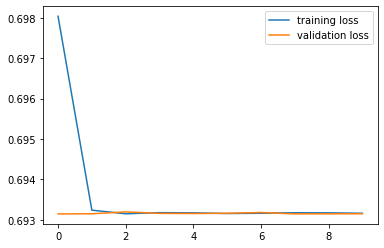

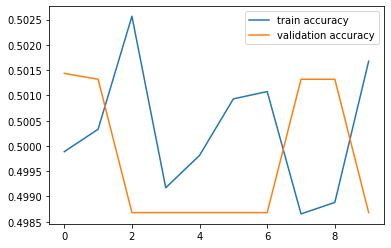

In [10]:
plt.figure()
plt.plot(hist.history['loss'], label='training loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.legend(loc='best')

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.legend(loc='best')
plt.show()

<a id='skip'></a> If you want to skip the training, just uncomment the first or the second cell under this text. But don't forget to recompile the model with desired (128/224) configuration.

In [11]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces128_baseline.h5
# _weights_name = 'maskedfaces128_baseline.h5'

In [12]:
# !wget https://data.belanec.eu/maskedface/weights/maskedfaces224_baseline.h5
# _weights_name = 'maskedfaces224_baseline.h5'

In [13]:
model.load_weights(_weights_name)

In [14]:
train_score = model.evaluate(train_generator)
print("\n\ntrain loss: {} | train acc: {}\n".format(train_score[0], train_score[1]))

test_score = model.evaluate(test_generator)
print("\n\ntest loss: {} | test acc: {}".format(test_score[0], test_score[1]))

1511/1511 [==============================] - 316s 209ms/step - loss: 0.6931 - accuracy: 0.5013


train loss: 0.6931440234184265 | train acc: 0.5012828707695007

314/314 [==============================] - 73s 233ms/step - loss: 0.6931 - accuracy: 0.5004


test loss: 0.693146824836731 | test acc: 0.5003737211227417


In [32]:
model_predictions = model.predict(test_generator)

In [31]:
preds = np.array(model_predictions > 0.5).astype(int).T[0]
labels = np.array(test_generator.classes)

f1 = f1_score(labels, preds)
print('F1 score: ', f1)

F1 score:  0.6670211351854315


## Conclusion

As we can see, our simple baseline model ended up really bad with accuracy 0.5 which is basically accuracy of coin toss. We will try to improve this using some pretrained model in our [next](https://github.com/Wicwik/ml-project/blob/master/maskedfaces_mobilenetv2.ipynb) notebook. The training of this model was around 6 minutes per epoch on 128x128 images and around 15 minutes per epoch on 224x224 images.

### 224x224 images
Our baseline models with 224x224 images ended up with results:
- train loss: 0.69
- train accuracy: 0.5
- test loss: 0.69
- test accuracy: 0.5
- F1 score: 0.67

### 128x128 images
Our baseline models with 224x224 images ended up with results:
- train loss: 0.69
- train accuracy: 0.5
- test loss: 0.69
- test accuracy: 0.5 
- F1 score: 0.67 